# **Anomaly Detection in Time Series Data using Ensemble Models**

This notebook demonstrates how to build and evaluate individual anomaly detection models and then create an ensemble of these models for improved performance.

## **Table of Contents**

1. [Data Preparation](#data-preparation)
2. [Build and Evaluate Individual Models](#individual-models)
   - [Matrix Profile](#matrix-profile)
   - [Isolation Forest](#isolation-forest)
   - [Autoencoder](#autoencoder)
   - [Convolutional Neural Network (CNN)](#cnn)
3. [Build and Evaluate Ensemble Model](#ensemble-model)
4. [Analyze Results](#analyze-results)
5. [Optimize Models and Ensemble](#optimize-models)
6. [Conclusion](#conclusion)


In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import load_model
import keras
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from matplotlib.backends.backend_pdf import PdfPages


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from commons import create_sequences, load_data, add_advanced_time_features, add_lag_features, filter_and_save_data, scale_data, scale_selected_columns, preprocess_data_without_scaling, preprocess_data_with_scaling, plot_anomalies
from commons import timesteps, data_file_path, time_column, target_column, train_data_split, train_data_path, eval_data_path, eval_data_labeled_path, anomaly_trashold   # Variables which are shared across the application

In [2]:
#deprecated
def plot_reconstruction_error(data, time_column, reconstruction_error, threshold, title="Reconstruction Error with Anomalies"):
    """
    Plots the reconstruction error over time and highlights points exceeding the anomaly threshold.
    
    Parameters:
    - data: pd.DataFrame containing the dataset
    - time_column: str, name of the time column
    - reconstruction_error: np.array, reconstruction error values
    - threshold: float, anomaly threshold
    - title: str, plot title
    """
    
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot the reconstruction error over time
    ax.plot(data[time_column], reconstruction_error, label='Reconstruction Error', color='blue')

    # Highlight anomalies (points where reconstruction error exceeds the threshold)
    anomalies = data[reconstruction_error > threshold]
    ax.scatter(anomalies[time_column], reconstruction_error[reconstruction_error > threshold], 
               color='red', label='Anomalies', marker='x')

    # Add threshold line
    ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_combined_anomalies_only(data, time_column, value_column, predictions, title="Anomalies Detected"):
    """
    Plots the data with anomalies highlighted.
    
    Parameters:
    - data: pd.DataFrame containing the dataset
    - time_column: str, name of the time column
    - value_column: str, name of the value column (e.g., power output)
    - predictions: np.array, combined predictions from both models (1 for normal, -1 for anomaly)
    - title: str, plot title
    """
    
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot the actual data values over time
    ax.plot(data[time_column], data[value_column], label='Data', color='blue')

    # Highlight anomalies in red
    anomalies = data[predictions == -1]
    ax.scatter(anomalies[time_column], anomalies[value_column], color='red', label='Anomalies', marker='x')

    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel(value_column)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_combined_anomalies(data, time_column, value_column, ensemble_type, title=None):
    """
    Plots the data and highlights anomalies detected by different models whose predictions are stored in the DataFrame columns.

    Parameters:
    - data: pd.DataFrame, the original data with time and value columns, and prediction columns
    - time_column: str, name of the time column
    - value_column: str, name of the column with values to plot
    - ensemble_type: str, the type of ensemble method used
    - title: str or None, title of the plot. If None, a default title is generated
    """
    import matplotlib.pyplot as plt

    # Ensure the time column is in datetime format
    data[time_column] = pd.to_datetime(data[time_column])

    # Set default title if not provided
    if title is None:
        title = f"Anomalies Detected by Ensemble with {ensemble_type}"

    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot the original data
    ax.plot(data[time_column], data[value_column], label='Original Data', color='blue')

    # Define colors and markers
    colors = ['orange', 'red', 'green', 'purple', 'cyan', 'magenta']
    markers = ['x', 'o', '^', 's', 'd', '*']

    # Get prediction columns dynamically
    prediction_columns = [col for col in data.columns if col.endswith('_prediction')]

    for idx, pred_col in enumerate(prediction_columns):
        anomalies = data[data[pred_col] == -1]
        model_label = pred_col.replace('_prediction', '').replace('_', ' ').title() + ' Anomalies'
        ax.scatter(
            anomalies[time_column], anomalies[value_column],
            color=colors[idx % len(colors)],
            marker=markers[idx % len(markers)],
            label=model_label
        )

    # Labels and title
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel(value_column)
    plt.legend()
    plt.grid(True)
    plt.show()


def load_models(models_info):
    import joblib
    from tensorflow.keras.models import load_model  # Use tensorflow.keras
    models = {}
    scalers = {}

    for model_name, info in models_info.items():
        model_path = info['path']
        model_type = info['type']
        scaler_path = info.get('scaler')

        # Load the model
        if model_type == 'sklearn':
            models[model_name] = joblib.load(model_path)
        elif model_type == 'keras':
            models[model_name] = load_model(model_path)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Load the scaler if it exists
        if scaler_path:
            scalers[model_name] = joblib.load(scaler_path)
        else:
            scalers[model_name] = None
    return models, scalers


def scale_selected_columns(data, feature_columns_to_scale, scaler):
    """
    Scales only the specified columns in the dataset using the provided scaler.

    Parameters:
    - data (pd.DataFrame): The dataset with features to scale.
    - feature_columns_to_scale (list): List of column names to be scaled.
    - scaler (object): An instance of a scaler (e.g., StandardScaler or MinMaxScaler).

    Returns:
    - data (pd.DataFrame): The dataset with only the specified columns scaled.
    """
    # Copy the dataset to avoid modifying the original data
    data_scaled = data.copy()

    # Apply the scaler to the selected columns
    data_scaled[feature_columns_to_scale] = scaler.transform(data[feature_columns_to_scale])

    return data_scaled



def make_predictions(models, preprocessed_data, data, ocsvm_threshold=anomaly_trashold):
    """
    Makes predictions using each model and stores the predictions in the data DataFrame.

    Parameters:
    - models: dict, contains loaded models
    - preprocessed_data: dict, contains preprocessed data for each model
    - data: pd.DataFrame, the original data where predictions will be stored
    - ocsvm_threshold: float, percentile threshold for OneClassSVM anomaly detection (default: 95th percentile)

    Returns:
    - data: pd.DataFrame, the data with predictions added
    """

    for model_name, model in models.items():
        prediction_col = f"{model_name}_prediction"

        # Make predictions based on model type
        if isinstance(model, (IsolationForest, OneClassSVM)):
            # For OneClassSVM, calculate decision function (anomaly scores) and apply dynamic threshold
            if isinstance(model, OneClassSVM):
                # Calculate decision function (anomaly scores)
                anomaly_scores = -model.decision_function(preprocessed_data)
                # Set a dynamic threshold based on the provided percentile
                threshold = np.percentile(anomaly_scores, ocsvm_threshold)
                # Label anomalies: -1 for anomaly, 1 for normal
                predictions = np.where(anomaly_scores > threshold, -1, 1)
            else:
                # For IsolationForest, we directly use the model's predictions (-1 for anomaly, 1 for normal)
                predictions = model.predict(preprocessed_data)

        elif isinstance(model, keras.Model):
          
            
            # Check if the model is deep_autoencoder or an seq_autoencoder based on its name
            if "autoencoder_deep" in model_name.lower():
                reconstructed_data = model.predict(preprocessed_data)  # Use non-sequence data if that’s how it was trained.
                reconstruction_error = np.mean(np.abs(preprocessed_data - reconstructed_data), axis=1)
                threshold = np.percentile(reconstruction_error, anomaly_trashold)
                predictions = np.where(reconstruction_error > threshold, -1, 1)
               
            elif "autoencoder_seq" in model_name.lower():

                if preprocessed_data.shape[0] >= timesteps:
                    preprocessed_data_seq  = create_sequences(preprocessed_data, timesteps)
                else:
                    raise ValueError("Not enough samples to create the required sliding windows.")
                # For Autoencoder, compute reconstruction error
                reconstructed_data = model.predict(preprocessed_data_seq)

                                
                if reconstructed_data.shape != preprocessed_data_seq.shape:
                    # The autoencoder returns only one timestep per sequence.
                    print("Using sequence-to-one error calculation (comparing last time step)")
                    # Compare only the last time step in each sequence with the model output.
                    reconstruction_error = np.mean(np.abs(preprocessed_data_seq[:, -1, :] - reconstructed_data), axis=1)
                else:
                    print("Using full sequence error calculation")
                    reconstruction_error = np.mean(np.abs(preprocessed_data_seq - reconstructed_data), axis=(1, 2))
                
                #reconstruction_error = np.mean(np.abs(preprocessed_data_seq - reconstructed_data), axis=(1, 2))
                # Set a dynamic threshold (e.g., 95th percentile)
                threshold = np.percentile(reconstruction_error, anomaly_trashold)
                # Label anomalies: -1 for anomaly, 1 for normal
                predictions_seq = np.where(reconstruction_error > threshold, -1, 1)
                
                # Create a full-length predictions array and pad the first (timesteps - 1) rows.
                predictions = np.ones(preprocessed_data.shape[0], dtype=int)  # default to 1 (normal)
                predictions[timesteps - 1:] = predictions_seq
        else:
            raise ValueError(f"Unsupported model instance: {model}")

        # Store predictions in the DataFrame
        data[prediction_col] = predictions

    return data

def weighted_average_ensemble(predictions_matrix, weights):
    """
    Computes a weighted average ensemble prediction.
    
    Parameters:
    - predictions_matrix: np.array of shape (n_samples, n_models) containing base model predictions (-1 or 1)
    - weights: list or np.array of weights for each model; length must equal n_models.
    
    Returns:
    - final_predictions: np.array of shape (n_samples,) with ensemble predictions (-1 for anomaly, 1 for normal)
    """
    weights = np.array(weights)
    # Ensure that weights sum to 1
    weights = weights / np.sum(weights)
    
    # Compute weighted sum for each sample
    weighted_sum = np.dot(predictions_matrix, weights)
    
    # If weighted sum is negative, flag as anomaly (-1); otherwise normal (1)
    final_predictions = np.where(weighted_sum < 0, -1, 1)
    return final_predictions

def stacking_ensemble_train(base_predictions, true_labels, meta_model):
    """
    Trains a meta-model using base model predictions.
    
    Although you pass true_labels as (-1, 1) where -1 indicates an anomaly,
    this function converts them internally to (1, 0) for training (1 for anomaly, 0 for normal).
    
    Parameters:
    - base_predictions: np.array of shape (n_samples, n_models)
    - true_labels: np.array of true anomaly labels (-1 for anomaly, 1 for normal)
    - meta_model: an instantiated classifier (e.g., XGBClassifier or RandomForestClassifier)
    
    Returns:
    - meta_model: trained meta-model.
    """
    # Convert labels: -1 (anomaly) -> 1 and 1 (normal) -> 0.
    y_meta = np.where(true_labels == -1, 1, 0)
    meta_model.fit(base_predictions, y_meta)
    return meta_model

def stacking_ensemble_predict(base_predictions, meta_model, threshold=0.5):
    """
    Uses the trained meta-model to make stacking ensemble predictions.
    
    The function outputs predictions as (-1 for anomaly, 1 for normal),
    converting the meta-model's (0, 1) prediction probabilities back accordingly.
    
    Parameters:
    - base_predictions: np.array of shape (n_samples, n_models)
    - meta_model: trained meta-model (e.g., XGBClassifier or RandomForestClassifier)
    - threshold: probability threshold to decide anomaly vs. normal
    
    Returns:
    - final_predictions: np.array of ensemble predictions (-1 for anomaly, 1 for normal)
    """
    # In the trained meta-model, class 1 corresponds to anomaly.
    anomaly_class_index = list(meta_model.classes_).index(1)
    anomaly_probs = meta_model.predict_proba(base_predictions)[:, anomaly_class_index]
    
    # If anomaly probability is above the threshold, return -1 (anomaly); else return 1 (normal)
    final_predictions = np.where(anomaly_probs >= threshold, -1, 1)
    return final_predictions

def create_performance_report_pdf(labeled_data, prediction_methods, output_filename="performance_report.pdf"):
    """
    Creates a PDF report containing performance summaries for each prediction method.
    
    For each method in `prediction_methods`, this function computes performance metrics
    (precision, recall, F1-score, ROC AUC, accuracy), plots the ROC curve and confusion matrix,
    and writes the results to a separate page in the PDF.
    
    Parameters:
    - labeled_data: pd.DataFrame containing the true labels in "anomaly_label" and the prediction columns.
    - prediction_methods: list of column names containing predictions.
    - output_filename: str, filename for the output PDF.
    """
   
    true_labels = labeled_data["anomaly_label"].values

    with PdfPages(output_filename) as pdf:
        for method in prediction_methods:
            if method not in labeled_data.columns:
                print(f"Prediction method column '{method}' not found in the DataFrame.")
                continue

            # Get predictions for the current method
            y_pred = labeled_data[method].values

            # Compute performance metrics (using -1 as the positive class for anomalies)
            precision = precision_score(true_labels, y_pred, pos_label=-1)
            recall = recall_score(true_labels, y_pred, pos_label=-1)
            f1 = f1_score(true_labels, y_pred, pos_label=-1)
            roc_auc = roc_auc_score((true_labels == -1).astype(int), (y_pred == -1).astype(int))
            accuracy = accuracy_score(true_labels, y_pred)

            # Compute confusion matrix
            cm = confusion_matrix(true_labels, y_pred, labels=[-1, 1])
            
            # Compute ROC curve data
            fpr, tpr, _ = roc_curve((true_labels == -1).astype(int), (y_pred == -1).astype(int))
            roc_auc_val = auc(fpr, tpr)

            # Dynamic titles for the report page
            dynamic_title = f"Performance Report for {method}"
            anomaly_vis_title = dynamic_title + " - Anomaly Visualization"

            # Create a figure with 5 subplots (Text, ROC, Confusion Matrix, Anomaly Visualization, and Bar Plot)
            fig = plt.figure(figsize=(12, 20))
            
            # Subplot 1: Performance metrics text summary
            ax_text = fig.add_subplot(5, 1, 1)
            ax_text.axis('off')
            text_str = (
                f"{dynamic_title}\n\n"
                f"Precision: {precision:.4f}\n"
                f"Recall: {recall:.4f}\n"
                f"F1-Score: {f1:.4f}\n"
                f"ROC AUC: {roc_auc:.4f}\n"
                f"Accuracy: {accuracy:.4f}\n"
            )
            ax_text.text(0.05, 0.5, text_str, fontsize=12, verticalalignment='center')
            
            # Subplot 2: ROC Curve
            ax_roc = fig.add_subplot(5, 1, 2)
            ax_roc.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
            ax_roc.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
            ax_roc.set_xlabel("False Positive Rate")
            ax_roc.set_ylabel("True Positive Rate")
            ax_roc.set_title("ROC Curve")
            ax_roc.legend(loc="lower right")
            ax_roc.grid(True)
            
            # Subplot 3: Confusion Matrix
            ax_cm = fig.add_subplot(5, 1, 3)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                        xticklabels=["Anomaly (-1)", "Normal (1)"],
                        yticklabels=["Anomaly (-1)", "Normal (1)"],
                        ax=ax_cm)
            ax_cm.set_xlabel("Predicted Label")
            ax_cm.set_ylabel("True Label")
            ax_cm.set_title("Confusion Matrix")
            
            # Subplot 4: Anomaly Visualization (similar to plot_combined_anomalies_only)
            ax_anom = fig.add_subplot(5, 1, 4)
            # Plot the original time series
            ax_anom.plot(labeled_data['Time'], labeled_data['Inv 1 AC-Leistung (W)'], label='Data', color='blue')
            # Overlay anomalies (points where prediction == -1)
            anomalies = labeled_data[labeled_data[method] == -1]
            ax_anom.scatter(anomalies['Time'], anomalies['Inv 1 AC-Leistung (W)'], 
                            color='red', label='Anomalies', marker='x')
            ax_anom.set_title(anomaly_vis_title)
            ax_anom.set_xlabel('Time')
            ax_anom.set_ylabel('Inv 1 AC-Leistung (W)')
            ax_anom.legend()
            ax_anom.grid(True)
            
            # Subplot 5: Bar Plot for Metrics
            ax_bar = fig.add_subplot(5, 1, 5)
            bar_metrics = ["Precision", "Recall", "F1-Score", "ROC AUC", "Accuracy"]
            bar_values = [precision, recall, f1, roc_auc, accuracy]
            ax_bar.bar(bar_metrics, bar_values, color=['blue', 'green', 'red', 'purple', 'orange'])
            ax_bar.set_ylim(0, 1)
            ax_bar.set_xlabel("Evaluation Metrics")
            ax_bar.set_ylabel("Score")
            ax_bar.set_title("Anomaly Detection Model Evaluation Metrics")
            ax_bar.set_xticklabels(bar_metrics, rotation=45)
            ax_bar.grid(axis="y", linestyle="--", alpha=0.7)
            
            fig.suptitle(dynamic_title, fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig(fig)
            plt.close(fig)
            
        print(f"Performance report saved to {output_filename}")



<a id='data-preparation'></a>
## **1. Data Preparation**


**Normalize/Standardize Data**


<a id='ensemble-model'></a>
## **3. Build and Evaluate Ensemble Model**


## Load all models

In [3]:
# 1. Define the models dictionary
models_info = {
    'iso_forest': {
        'path': f'USModels/isolation_forest_model_{timesteps}.pkl',
        'type': 'sklearn',
        'scaler': f'USModels/scaler_iso_forest_{timesteps}.pkl'
        #'scaler': None
    },
    'autoencoder_seq': {
        'path': f'USModels/best_seq_autoencoder_model_{timesteps}.keras',
        'type': 'keras',
        'scaler': f'USModels/scaler_ae_{timesteps}.pkl'
    },
#    'lstm': {
 #       'path': 'USModels/lstm_forecaster_model.keras',
#        'type': 'keras',
#        'scaler': 'USModels/scaler_ae.pkl'
#    },
#    'autoencoder_deep': {
#        'path': f'USModels/best_deep_autoencoder_model_{timesteps}.keras',
#        'type': 'keras',
#        'scaler': f'USModels/scaler_ae_{timesteps}.pkl'
#    },
    'oc_svm': {
        'path': f'USModels/ocsvm_model_{timesteps}.pkl',
        'type': 'sklearn',
        'scaler': f'USModels/scaler_ocsvm_{timesteps}.pkl'
    }
}

# 2. Load the models and scalers dynamically
models, scalers = load_models(models_info)





In [4]:
labeled_data = preprocess_data_with_scaling(
    eval_data_labeled_path, 
    time_column, 
    target_column, 
    timesteps,
    scaler = scalers['iso_forest'],
    drop_time_column=False
)

labeled_data

NaN counts before preprocessing:
timestamp        0
value            0
anomaly_label    0
dtype: int64
NaN counts after adding time features:
timestamp        0
value            0
anomaly_label    0
hour             0
day              0
day_of_week      0
week_of_year     0
month            0
is_weekend       0
hour_sin         0
hour_cos         0
dtype: int64


,timestamp,value,anomaly_label,hour,day,day_of_week,week_of_year,month,is_weekend,hour_sin,hour_cos,lag_1,lag_2,lag_3,moving_mean_288,moving_std_288
3,2013-12-02 21:30:00,-1.104612,1,21,2,0,49,12,0,-0.707107,0.707107,-1.318498,-1.444508,-1.547202,-1.452463,-1.427049
4,2013-12-02 21:35:00,-0.978450,1,21,2,0,49,12,0,-0.707107,0.707107,-1.104548,-1.318433,-1.444437,-1.369001,-1.259119
5,2013-12-02 21:40:00,-1.044168,1,21,2,0,49,12,0,-0.707107,0.707107,-0.978384,-1.104479,-1.318360,-1.370163,-1.289894
6,2013-12-02 21:45:00,-0.878725,1,21,2,0,49,12,0,-0.707107,0.707107,-1.044103,-0.978313,-1.104404,-1.316021,-1.204090
7,2013-12-02 21:50:00,-0.878402,1,21,2,0,49,12,0,-0.707107,0.707107,-0.878658,-1.044033,-0.978237,-1.283450,-1.188411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,2014-02-19 15:05:00,1.022048,1,15,19,2,8,2,0,-0.707107,-0.707107,0.934668,1.019867,0.954904,0.624229,-0.892395
22691,2014-02-19 15:10:00,0.981600,1,15,19,2,8,2,0,-0.707107,-0.707107,1.022146,0.934770,1.019962,0.629319,-0.894401
22692,2014-02-19 15:15:00,0.910653,1,15,19,2,8,2,0,-0.707107,-0.707107,0.981697,1.022250,0.934865,0.633446,-0.894767
22693,2014-02-19 15:20:00,1.008408,1,15,19,2,8,2,0,-0.707107,-0.707107,0.910750,0.981800,1.022346,0.637529,-0.891058


In [5]:
# Drop the 'Time' column before fitting the model, as IsolationForest only accepts numeric features
labeled_data_numeric = labeled_data.drop(columns=[time_column, 'anomaly_label' ])
#labeled_data_numeric = labeled_data.drop(columns=['Time'])
print(labeled_data_numeric.head())

      value  hour  day  day_of_week  week_of_year  month  is_weekend  \
3 -1.104612    21    2            0            49     12           0   
4 -0.978450    21    2            0            49     12           0   
5 -1.044168    21    2            0            49     12           0   
6 -0.878725    21    2            0            49     12           0   
7 -0.878402    21    2            0            49     12           0   

   hour_sin  hour_cos     lag_1     lag_2     lag_3  moving_mean_288  \
3 -0.707107  0.707107 -1.318498 -1.444508 -1.547202        -1.452463   
4 -0.707107  0.707107 -1.104548 -1.318433 -1.444437        -1.369001   
5 -0.707107  0.707107 -0.978384 -1.104479 -1.318360        -1.370163   
6 -0.707107  0.707107 -1.044103 -0.978313 -1.104404        -1.316021   
7 -0.707107  0.707107 -0.878658 -1.044033 -0.978237        -1.283450   

   moving_std_288  
3       -1.427049  
4       -1.259119  
5       -1.289894  
6       -1.204090  
7       -1.188411  


In [6]:
# 5. Make predictions with each model
labeled_data = make_predictions(models, labeled_data_numeric, labeled_data)

# 6. Combine predictions
# For ensemble methods, you can dynamically retrieve the predictions
prediction_columns = [col for col in labeled_data.columns if col.endswith('_prediction')]

# Convert predictions to numerical values (-1 for anomaly, 1 for normal)
predictions_matrix = np.column_stack([labeled_data[col].values for col in prediction_columns])
labeled_data["combined_prediction_majority"] = np.where(np.sum(predictions_matrix, axis=1) < 0, -1, 1)

# (Assuming you have three models: iso_forest, autoencoder_seq, oc_svm)
weights = [0.4, 0.4, 0.2]  # You can adjust these weights based on validation performance.
labeled_data["combined_prediction_weighted"] = weighted_average_ensemble(predictions_matrix, weights)

# Combine predictions using Union (if any model flags an anomaly, it is considered an anomaly)
labeled_data["combined_prediction_union"] = np.where(np.any(predictions_matrix == -1, axis=1), -1, 1)

# Train the meta-model using the predictions from base models and known labels.
# Here, labeled_data["anomaly_label"] provides the true labels for training.
meta_model = stacking_ensemble_train(predictions_matrix, labeled_data["anomaly_label"].values, meta_model = LogisticRegression())

# Use the trained meta-model to make stacking ensemble predictions.
labeled_data["combined_prediction_stacking_logistic_reg"] = stacking_ensemble_predict(predictions_matrix, meta_model)

# Here, labeled_data["anomaly_label"] provides the true labels for training.
meta_model = stacking_ensemble_train(predictions_matrix, labeled_data["anomaly_label"].values, meta_model = RandomForestClassifier(random_state=42))

# Use the trained meta-model to make stacking ensemble predictions.
labeled_data["combined_prediction_stacking_random_for"] = stacking_ensemble_predict(predictions_matrix, meta_model)

# Here, labeled_data["anomaly_label"] provides the true labels for training.
meta_model = stacking_ensemble_train(predictions_matrix, labeled_data["anomaly_label"].values, meta_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))

# Use the trained meta-model to make stacking ensemble predictions.
labeled_data["combined_prediction_stacking_xgboost"] = stacking_ensemble_predict(predictions_matrix, meta_model)

710/710 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step  
Using full sequence error calculation


### Evaluation

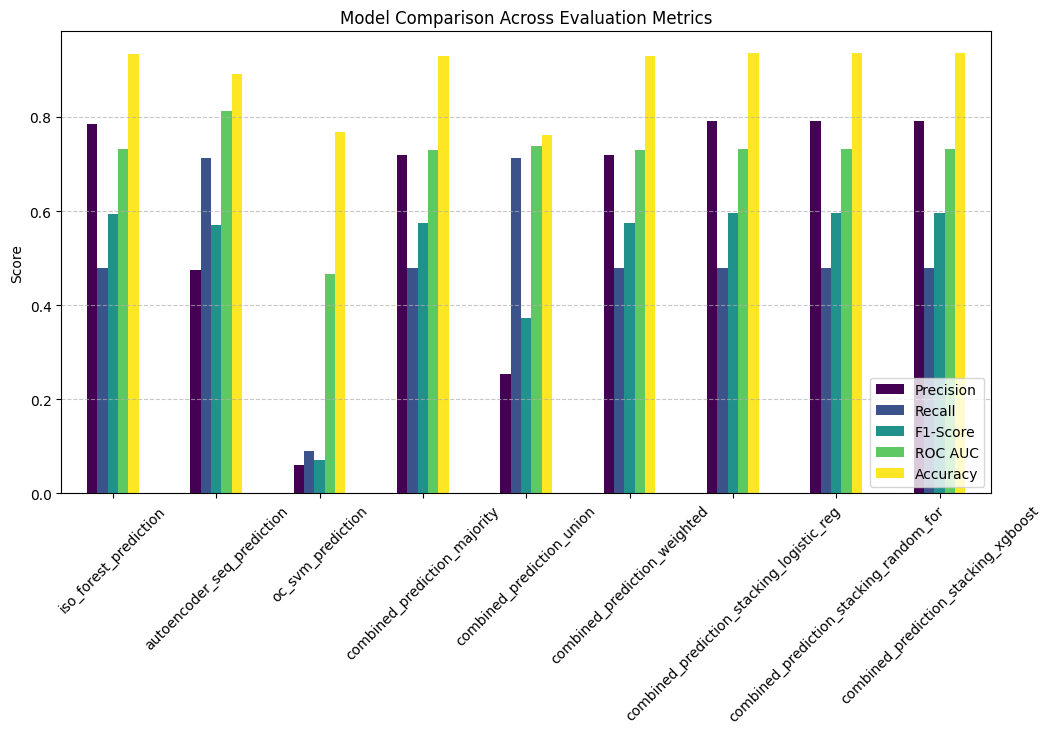

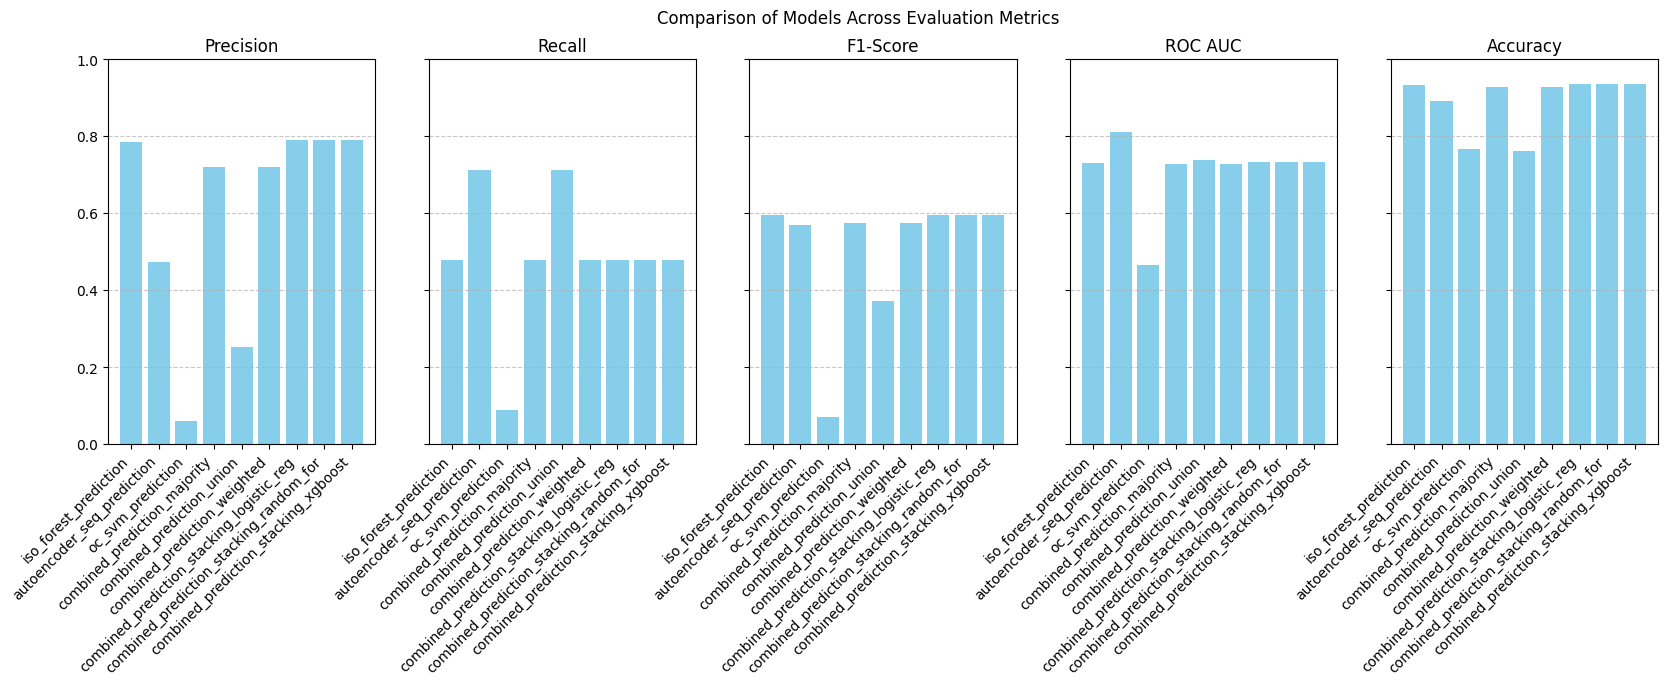

In [7]:
# Compare different prediction methods
comparison_results = {}


prediction_methods = ["iso_forest_prediction", 
                      "autoencoder_seq_prediction", 
                      "oc_svm_prediction", 
                      "combined_prediction_majority", 
                      "combined_prediction_union", 
                      "combined_prediction_weighted", 
                      "combined_prediction_stacking_logistic_reg", 
                      "combined_prediction_stacking_random_for",
                      "combined_prediction_stacking_xgboost"]



for method in prediction_methods:
    detected_anomalies = labeled_data[method].values
    precision = precision_score(labeled_data["anomaly_label"], detected_anomalies, pos_label=-1)
    recall = recall_score(labeled_data["anomaly_label"], detected_anomalies, pos_label=-1)
    f1 = f1_score(labeled_data["anomaly_label"], detected_anomalies, pos_label=-1)
    roc_auc = roc_auc_score((labeled_data["anomaly_label"] == -1).astype(int), (detected_anomalies == -1).astype(int))
    accuracy = accuracy_score(labeled_data["anomaly_label"], detected_anomalies)
    comparison_results[method] = [precision, recall, f1, roc_auc, accuracy]

# Visualization
metrics = ["Precision", "Recall", "F1-Score", "ROC AUC", "Accuracy"]
comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index', columns=metrics)
comparison_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.ylabel("Score")
plt.title("Model Comparison Across Evaluation Metrics")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Visualization
metrics = ["Precision", "Recall", "F1-Score", "ROC AUC", "Accuracy"]
comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index', columns=metrics)

# Bar plots per metric
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df.index, comparison_df[metric], color='skyblue')
    axes[i].set_title(metric)
    axes[i].set_xticklabels(comparison_df.index, rotation=45, ha='right')
    axes[i].set_ylim(0, 1)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Comparison of Models Across Evaluation Metrics")
plt.show()

In [8]:
comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index', columns=["Precision", "Recall", "F1-Score", "ROC AUC", "Accuracy"])
print(comparison_df)


                                           Precision    Recall  F1-Score  \
iso_forest_prediction                       0.785249  0.478836  0.594906   
autoencoder_seq_prediction                  0.475029  0.712963  0.570169   
oc_svm_prediction                           0.059929  0.089947  0.071932   
combined_prediction_majority                0.719682  0.478836  0.575060   
combined_prediction_union                   0.253131  0.712963  0.373614   
combined_prediction_weighted                0.719682  0.478836  0.575060   
combined_prediction_stacking_logistic_reg   0.791545  0.478836  0.596703   
combined_prediction_stacking_random_for     0.791545  0.478836  0.596703   
combined_prediction_stacking_xgboost        0.791545  0.478836  0.596703   

                                            ROC AUC  Accuracy  
iso_forest_prediction                      0.732147  0.934823  
autoencoder_seq_prediction                 0.812734  0.892561  
oc_svm_prediction                          0.46

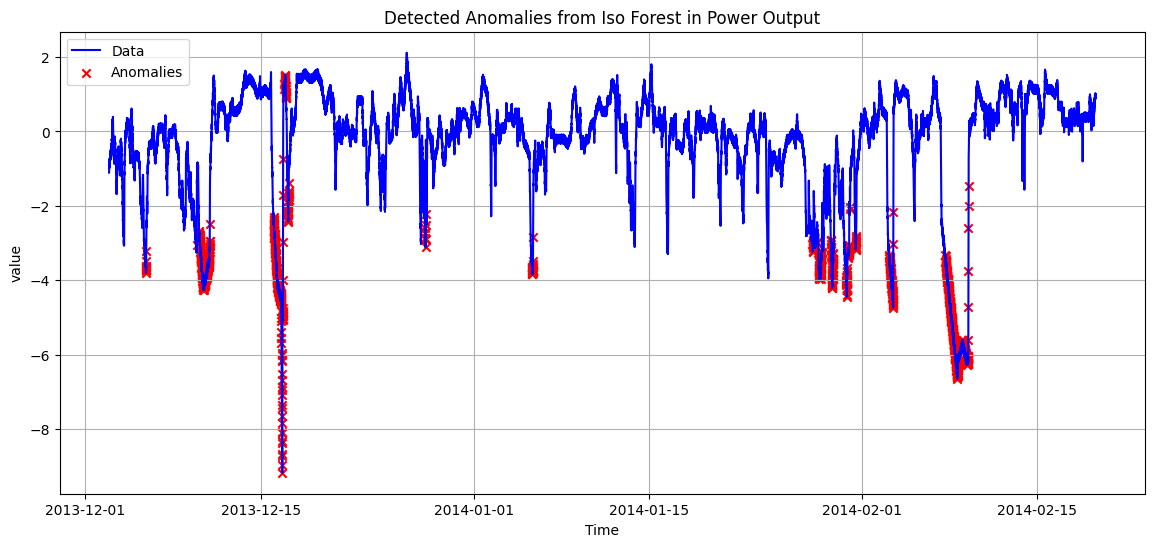

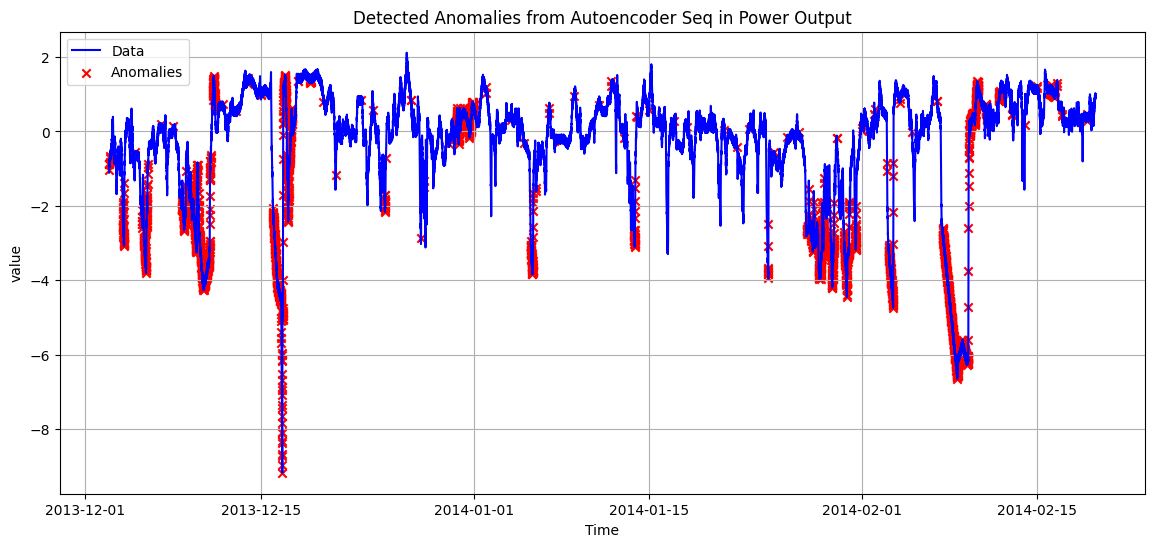

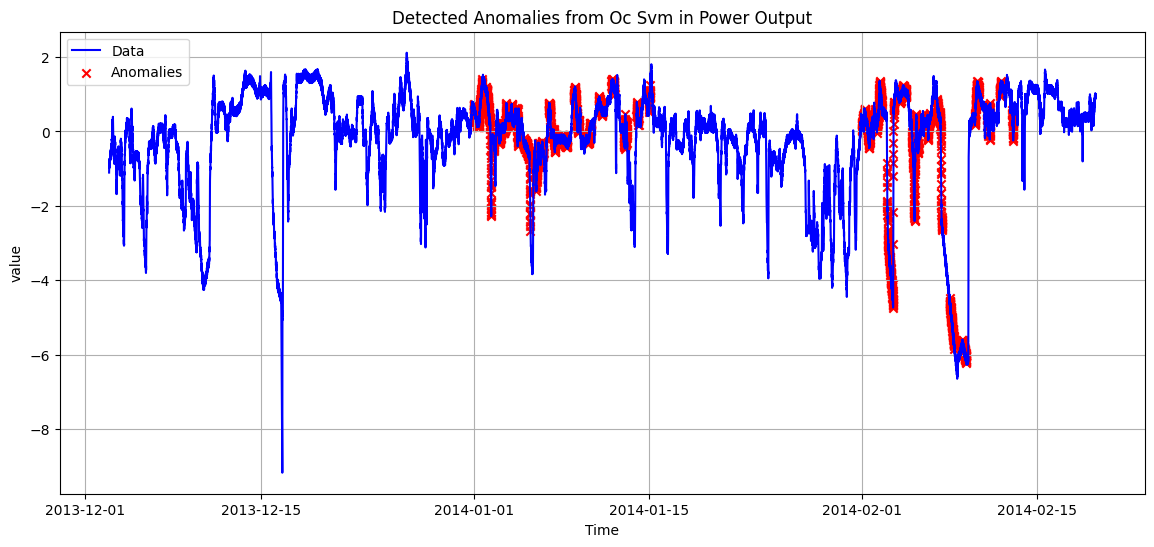

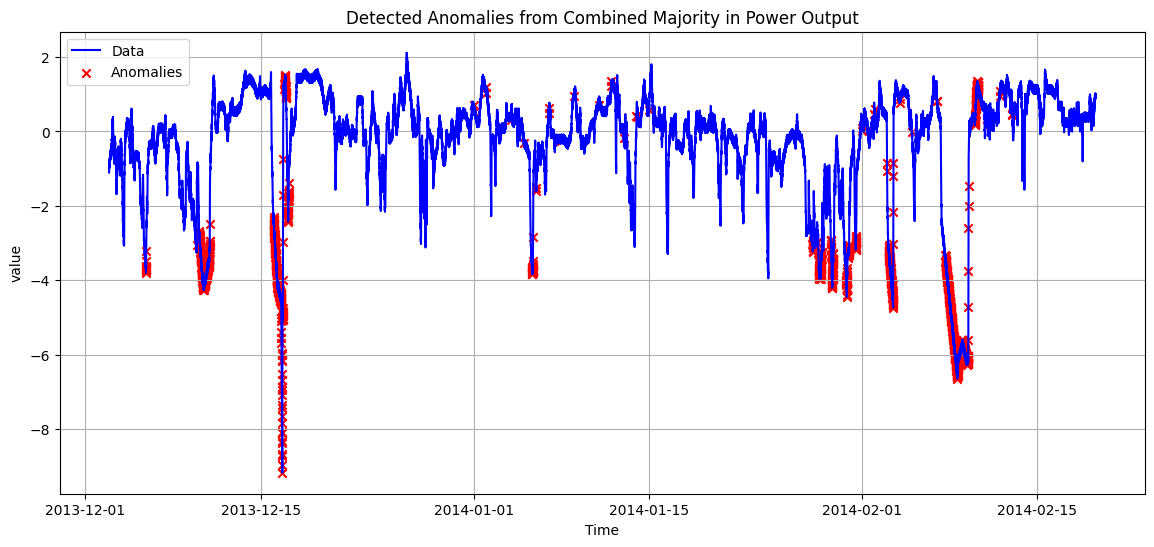

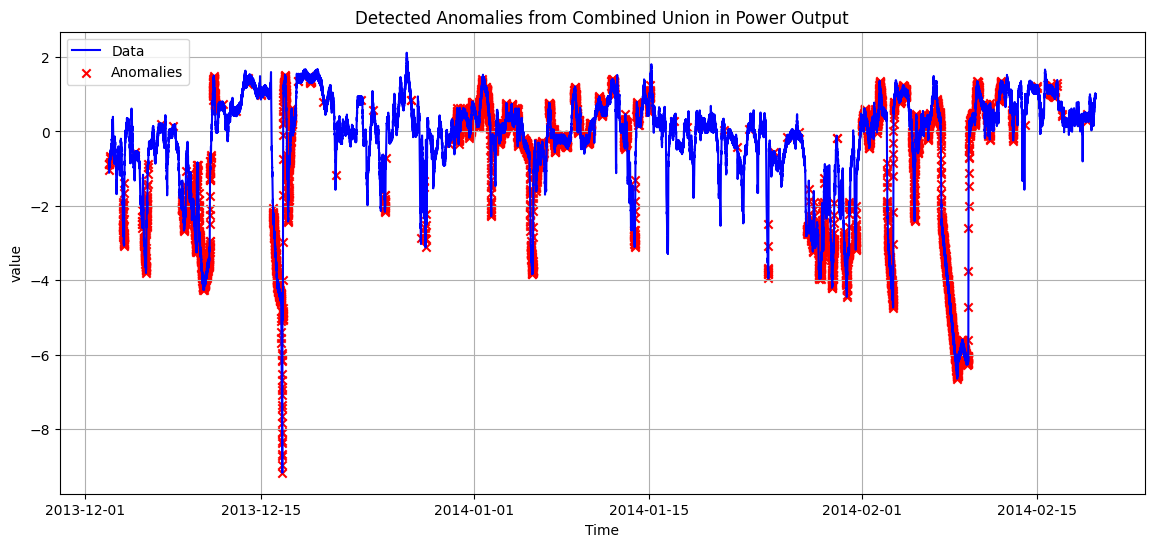

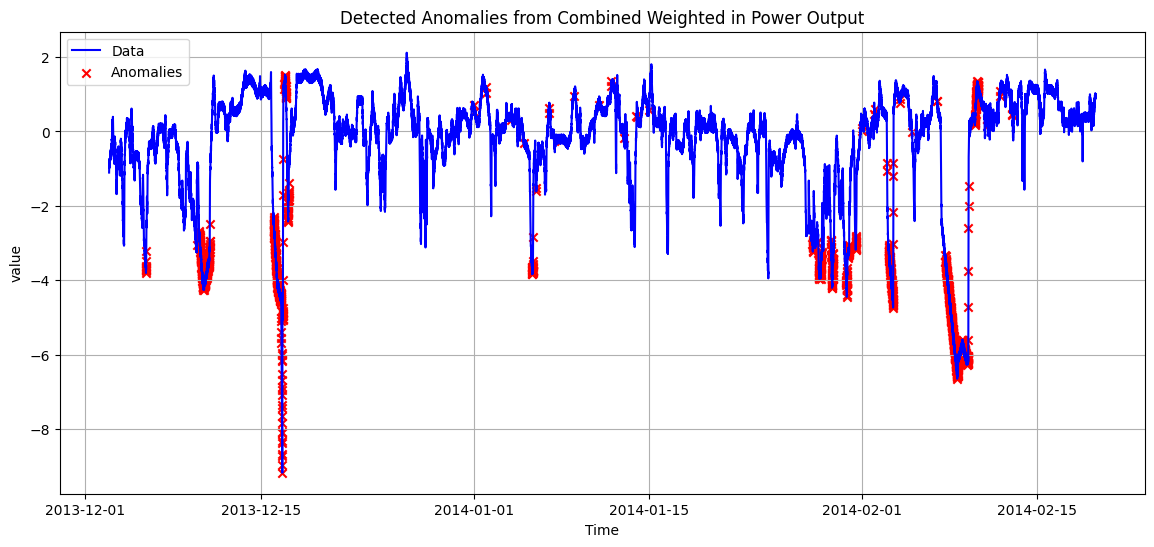

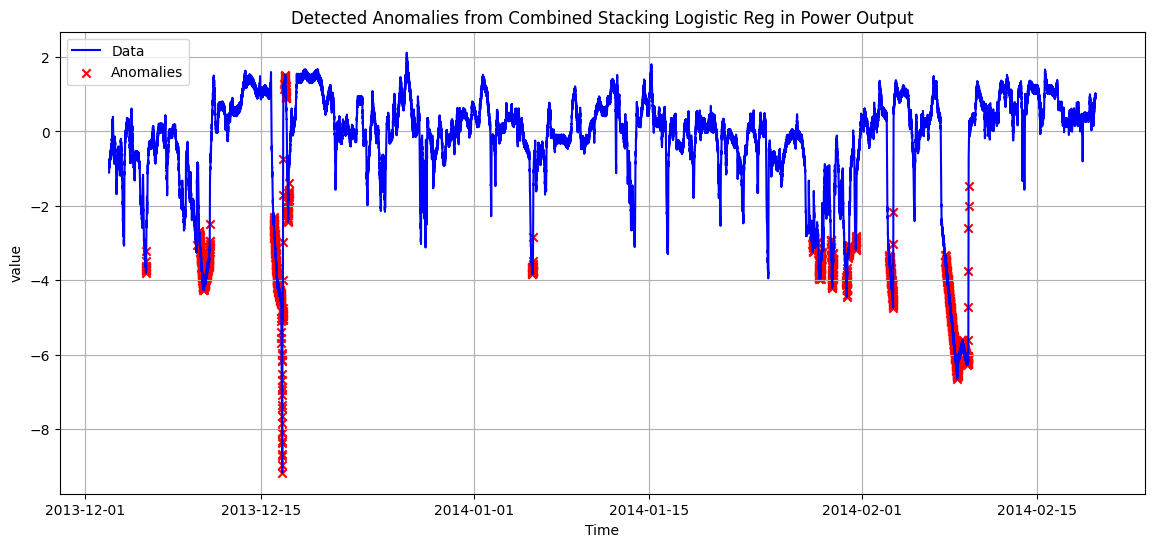

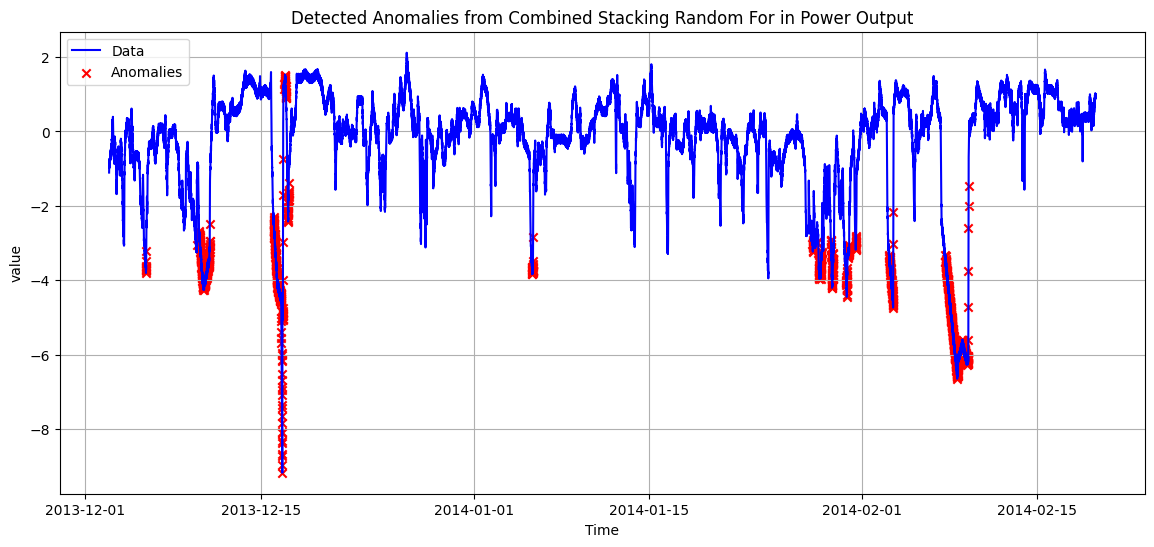

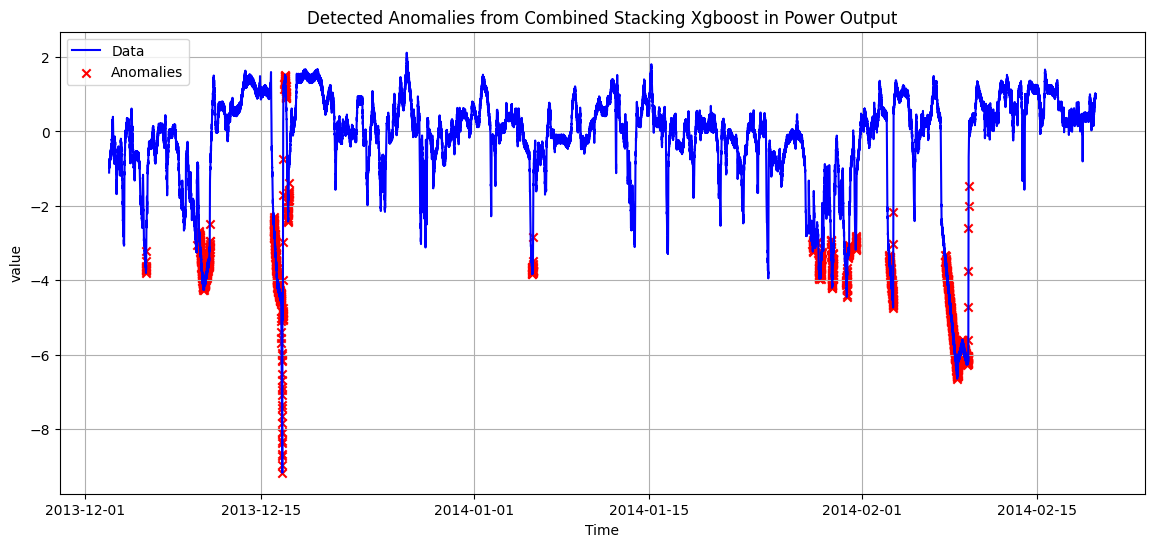

In [9]:
# Loop through each prediction method and plot the anomalies
for method in prediction_methods:
    # Check if the current prediction column exists in the DataFrame
    if method in labeled_data.columns:
        # Create a dynamic title by formatting the method name
        title = (
            f"Detected Anomalies from {method.replace('_prediction', '').replace('_', ' ').title()} in Power Output"
        )
        # Call the plotting function with the dynamic predictions column
        plot_combined_anomalies_only(
            data=labeled_data,                  # The DataFrame containing the dataset
            time_column=time_column,                     # The name of the time column
            value_column=target_column,   # The value column (e.g., power output)
            predictions=labeled_data[method].values,  # Dynamically use the prediction values
            title=title                             # Dynamic title for the plot
        )
    else:
        print(f"Column '{method}' not found in the DataFrame.")

KeyError: 'Time'

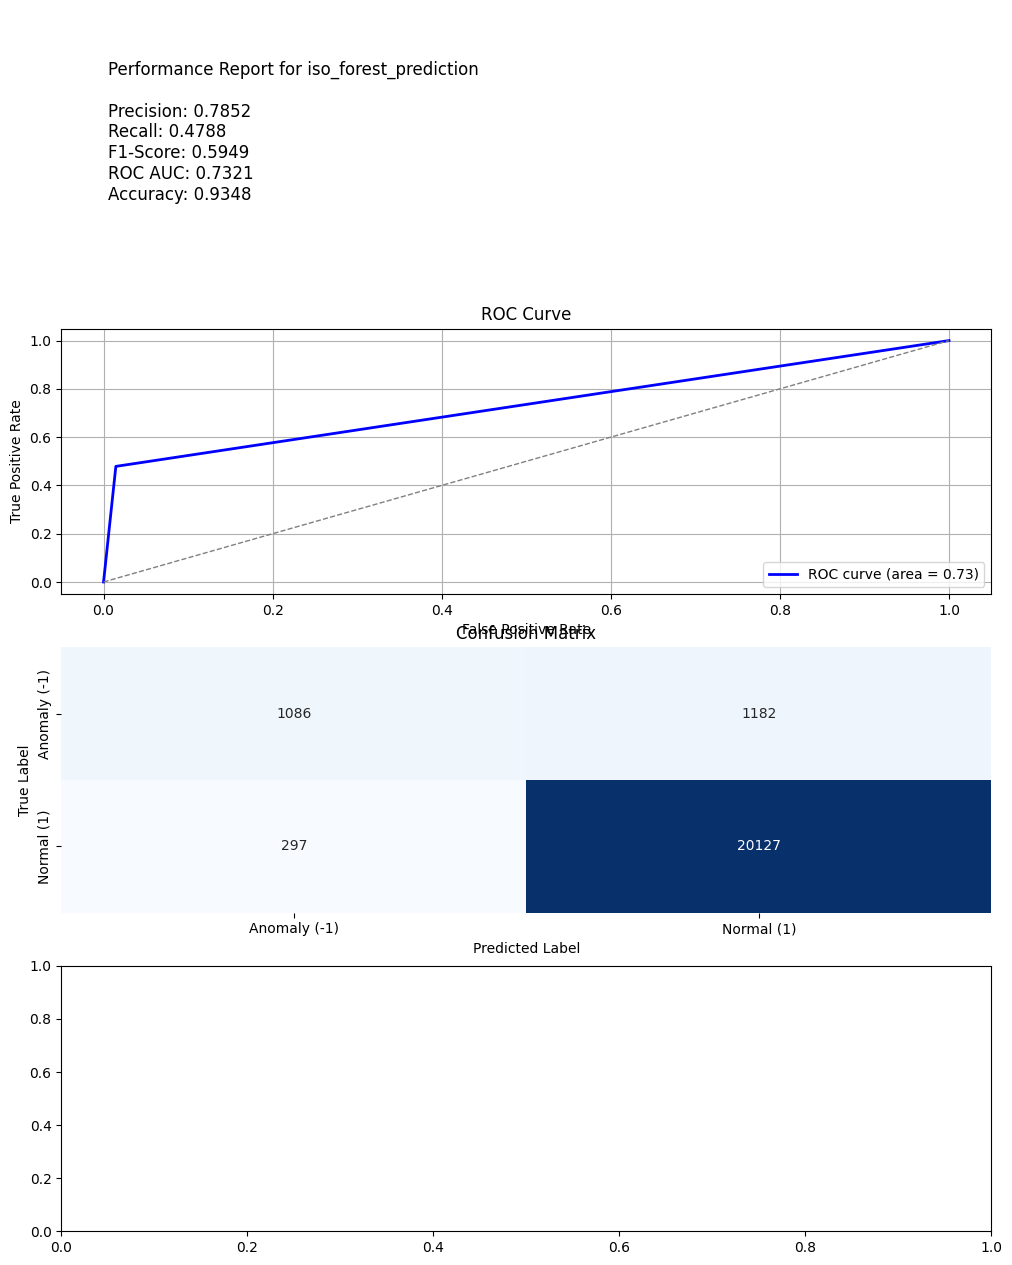

In [10]:
create_performance_report_pdf(labeled_data, prediction_methods, output_filename=F'reports/Anomaly_Detection_Performance_{timesteps}.pdf')

### Code for later use

In [ ]:
predictions = labeled_data["anomaly_label"].values
#Majoroty voting
#detected_anomalies = labeled_data["combined_prediction"].values
# Union of all anomalies
detected_anomalies = labeled_data["combined_prediction_union"].values

precision = precision_score(predictions, detected_anomalies, pos_label=-1)
recall = recall_score(predictions, detected_anomalies, pos_label=-1)
f1 = f1_score(predictions, detected_anomalies, pos_label=-1)
roc_auc = roc_auc_score((predictions == -1).astype(int), (detected_anomalies == -1).astype(int))
accuracy = accuracy_score(predictions, detected_anomalies)
conf_matrix = confusion_matrix(predictions, detected_anomalies)

# Print evaluation results
print("Evaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


### Visualisation 

In [ ]:
metrics = ["Precision", "Recall", "F1-Score", "ROC AUC", "Accuracy"]
values = [precision, recall, f1, roc_auc, accuracy]
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylim(0, 1)
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("Anomaly Detection Model Evaluation Metrics")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve((predictions == -1).astype(int), (detected_anomalies == -1).astype(int))
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Anomaly", "Normal"], yticklabels=["Anomaly", "Normal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Save Predictions

In [ ]:
labeled_data.to_csv("SolarEdge_Last_200_Days_With_Predictions.csv", index=False)

## Archive code dependent on labels which I dont have for unsupervized learning

<a id='analyze-results'></a>
## **4. Analyze Results**


<a id='conclusion'></a>
## **6. Conclusion**

- **Optimized Individual Models**: Hyperparameter tuning was performed on Matrix Profile, Autoencoder, and CNN models.
- **Improved Performance**: Each model showed performance improvements after optimization.
- **Enhanced Ensemble Model**: The ensemble model was updated with optimized models, leading to better overall performance.
- **Weighted Ensemble**: Assigning weights based on individual model performance further improved the ensemble's effectiveness.
- **Future Work**: Further optimization can be done using more sophisticated techniques like Bayesian Optimization, and additional models can be incorporated into the ensembleparameters.


